# Switching Linear Dynamical System

In this notebook, we implement a hierarchical state-space model: the switching linear dynamical system (SLDS). These models are useful for modeling time-series that 1.) experience abrupt changes in the underlying dynamics or 2.) are nonlinear, but can be described as being roughly piecewise linear. These models have an intractable posterior distribution, and so we make use of a Variational EM approach. For a discussion on our current VI approach refer to: *Variational Learning for Switching State-Space Models* by Zhoubin Gharamani and Geoffrey Hinton. iN this specific example, we will assume both a Gaussian state and observation model.

## Setup

In [60]:
# import the relevant packages
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using LaTeXStrings


## Simulate Data from an SLDS

In [76]:
using StateSpaceDynamics: LinearDynamicalSystem, GaussianStateModel, GaussianObservationModel

state_dim = 2
obs_dim = 10
K = 2 # two states

# Create the HMM parameters
A_hmm = [0.92 0.08; 0.06 0.94]
π₀ = [1.0, 0.0]

# Create the state models
A₁ = 0.95 * [cos(0.05) -sin(0.05); sin(0.05) cos(0.05)] # slower oscillator
A₂ = 0.95 * [cos(0.55) -sin(0.55); sin(0.55) cos(0.55)] # faster oscillator

Q₁ = [0.001 0.0; 0.0 0.001]
Q₂ = [0.1 0.0; 0.0 0.1]

# Assume same initial distribution for ease
x0 = [0.0, 0.0]
P0 = [0.1 0.0; 0.0 0.1]

# create the observation models
C₁ = randn(obs_dim, state_dim)
C₂ = randn(obs_dim, state_dim)

R = Matrix(0.1 * I(obs_dim)) # Assume same noise covariance for both states

# Put it all together for an SLDS model
model = SwitchingLinearDynamicalSystem(
    A_hmm,
    [LinearDynamicalSystem(GaussianStateModel(A₁, Q₁, x0, P0), GaussianObservationModel(C₁, R), state_dim, obs_dim, fill(true, 6)), 
     LinearDynamicalSystem(GaussianStateModel(A₂, Q₂, x0, P0), GaussianObservationModel(C₂, R), state_dim, obs_dim, fill(true, 6))],
     π₀,
    K)



SwitchingLinearDynamicalSystem([0.92 0.08; 0.06 0.94], LinearDynamicalSystem[LinearDynamicalSystem{GaussianStateModel{Float64}, GaussianObservationModel{Float64}}(GaussianStateModel{Float64}([0.9488127473752179 -0.04748021080714441; 0.04748021080714441 0.9488127473752179], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), GaussianObservationModel{Float64}([1.106732413275639 -0.1184114675008614; 0.1167982662110754 0.2859338957558448; … ; 0.46754181600090605 -0.07544856361297822; 1.493798274255364 1.4229717187590378], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), LinearDynamicalSystem{GaussianStateModel{Float64}, GaussianObservationModel{Float64}}(GaussianStateModel{Float64}([0.8098982959565304 -0.49655286748412625; 0.49655286748412625 0.8098982959565304], [0.1 0.0; 0.0 0.1], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), GaussianObservationModel{Float64}([0.14346311333442346 -0.2659607386908056; -0.886448032853083 1.323928748

In [77]:
T = 1000
# Generate synthetic data
x, y, z = StateSpaceDynamics.sample(model, T)

([0.011931643959443693 0.00993321438280238 … -0.5261725143473751 -0.9093749923595515; -0.004128388792910682 0.03207116915785779 … 1.3218514379771578 0.789747801782625], [0.34965573399179606 0.14757902780023835 … -0.311398409886266 -0.4104532363435115; -0.32552921536502677 0.18106215101138 … 2.7284142016559016 1.7235500897063505; … ; -0.0470652588619056 0.11962453688314048 … -0.17795908664895227 -0.13848810390603697; -0.1305160040247571 -0.009919669911591544 … -1.2592048210389464 0.22144313668546434], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

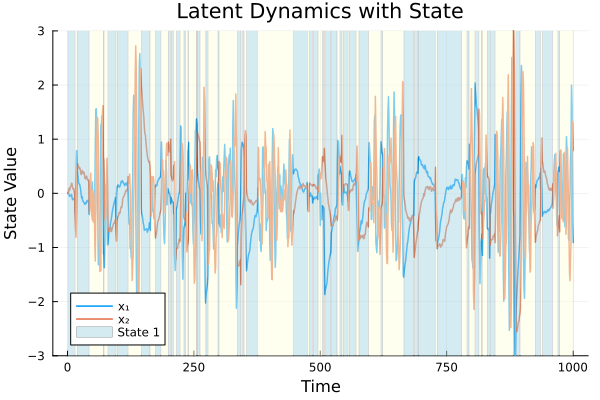

In [112]:
# Assuming x, y, z are already defined from previous code
plot(1:T, x[1, :], label="x₁",  linewidth=1.5)
plot!(1:T, x[2, :], label="x₂", linewidth=1.5)

# Create a background shading based on the state (z)
vspan_indices = findall(diff(z) .!= 0)
push!(vspan_indices, T)  # Add the end of the series
start_idx = 1
current_state = z[1]

for end_idx in vspan_indices
    # Choose color based on state value
    bg_color = current_state == 1 ? :lightblue : :lightyellow
    
    # Add a background shading for this state region
    vspan!([start_idx, end_idx], fillalpha=0.5, color=bg_color, 
           label=(start_idx == 1 ? "State $current_state" : ""))
    
    # Prepare for next region
    if end_idx < T
        start_idx = end_idx + 1
        current_state = z[start_idx]
    end
end

# Adjust the plot appearance
title!("Latent Dynamics with State")
xlabel!("Time")
ylabel!("State Value")
ylims!(-3, 3)


## Fit an SLDS model to the data

In [64]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.7 0.3; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.001 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.001 * I(d))

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.1 * I(p))

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6)) for (i,f) in zip(1:K, [0.7, 0.1])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.7 0.3; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.726600077920264 -0.6120068028758064; 0.6120068028758064 0.726600077920264], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([1.0548426197090242 -0.5314211023224301; -0.6474332415107721 0.1271760215776717; … ; -0.6187600545042322 0.04491788725458301; 0.75661587672164 0.16538516227614086], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581

In [44]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=25)

Fitting SLDS via vEM... 100%|██████████████████████████████████████████████████| Time: 0:00:27 (27.16 ms/it)


([-5537.147536270802, -4907.099604921061, -4724.0017786900025, -4679.819181243036, -4656.924764753209, -4641.581443818863, -4632.16164310312, -4627.395044875131, -4626.149941511494, -4627.445334015341  …  -4697.126424108813, -4697.245597211665, -4697.338295212048, -4697.4089437072835, -4697.461307342422, -4697.498568082157, -4697.523402330984, -4697.538052541913, -4697.544391505899, -4697.5439788803105], [6.025558056075231, 1.5968529907022913, 0.34699741157365366, 0.2751080806053548, 0.21252438250980749, 0.16868677627789597, 0.14044669570423615, 0.11790339885480194, 0.09826601002086942, 0.08133716767059918  …  0.010062160583391544, 0.009385899505905524, 0.008824170602797747, 0.00835879475102215, 0.00797222640331353, 0.0076488150706309705, 0.007375328592935933, 0.007140994251038305, 0.006937272579163158, 0.00675751753174373], StateSpaceDynamics.ForwardBackward{Float64}([-0.05262385169476941 -0.1883651735898143 … -0.414734266381184 -0.32260331534513415; -0.07174046926154021 -0.3363717886

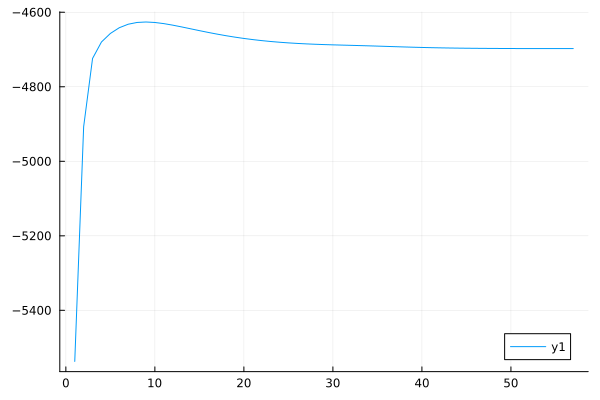

In [45]:
plot(mls)

In [46]:
diff(mls)

56-element Vector{Float64}:
 630.0479313497417
 183.0978262310582
  44.18259744696661
  22.894416489826654
  15.343320934346593
   9.419800715742895
   4.766598227988652
   1.2451033636370994
  -1.2953925038473244
  -3.0260552880608884
   ⋮
  -0.1191731028520735
  -0.09269800038327958
  -0.07064849523521843
  -0.05236363513813558
  -0.03726073973575694
  -0.024834248826664407
  -0.014650210929175955
  -0.0063389639853994595
   0.00041262558806920424

In [47]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [48]:
modeli.A

2×2 Matrix{Float64}:
 0.820204    0.179796
 3.41066e-6  0.999997

In [49]:
function reinitialize_state!(slds::SwwitchingLinearDynamicalSystem, tol::Float64=1e-6)
    # Grab important parameters
    A, K = slds.A, slds.k

    # iterate through each state, find states taht are degenerate
    degenerate_states = []

    for i in 1:K 
        for j in 1:K
            if A[i, j] < tol # check if a transition becomes mostly zero indicating state death
                push!(degenerate_states, j)
            end
        end
    end

    # reset the degenerate state to a random non-degenerate state with some noise 

end

UndefVarError: UndefVarError: `SwwitchingLinearDynamicalSystem` not defined

In [50]:
modeli.A .< 1e-3

2×2 BitMatrix:
 0  0
 1  0

In [51]:
for i in 1:2
    for j in 1:2
        println(modeli.A[i, j])
    end
end

0.8202040969599222
0.17979590304010695
3.4106573497643596e-6
0.9999965893426493


In [52]:
diff(mls) .> 0

56-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 1

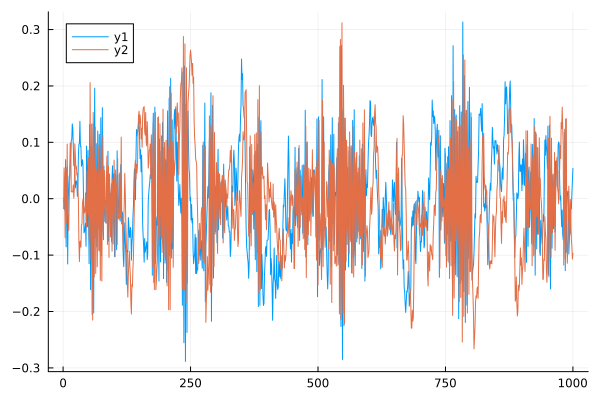

In [53]:
plot(x')


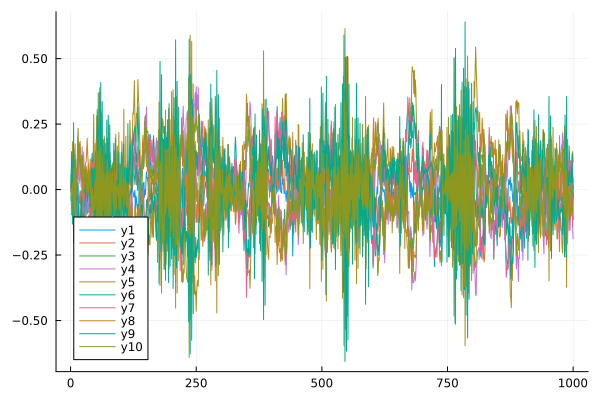

In [54]:
plot(y')

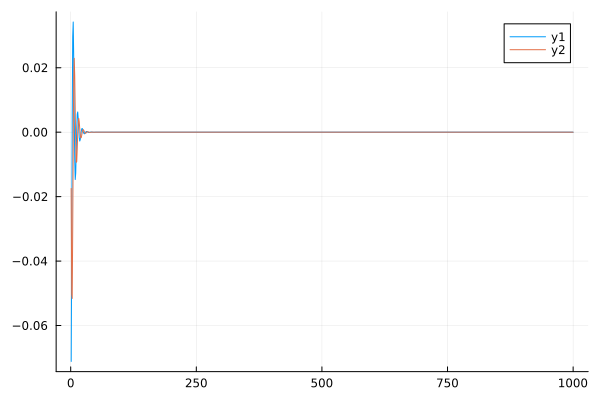

In [55]:
plot(FS[1].x_smooth')

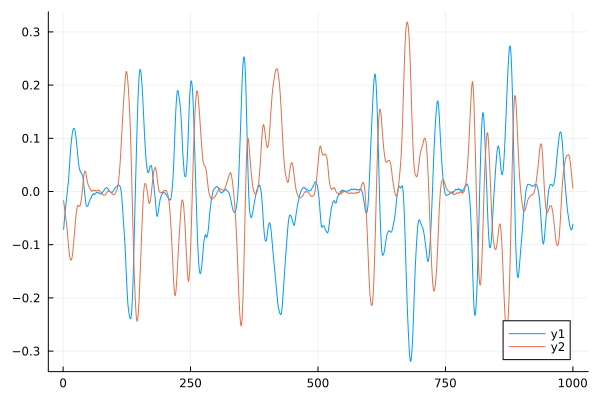

In [56]:
plot(FS[2].x_smooth')

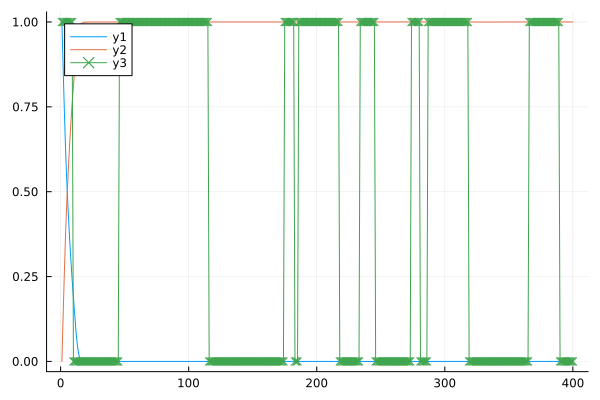

In [57]:
plot(exp.(FB.γ[:,1:400])')
plot!(z[1:400] .- 1, marker=:x)

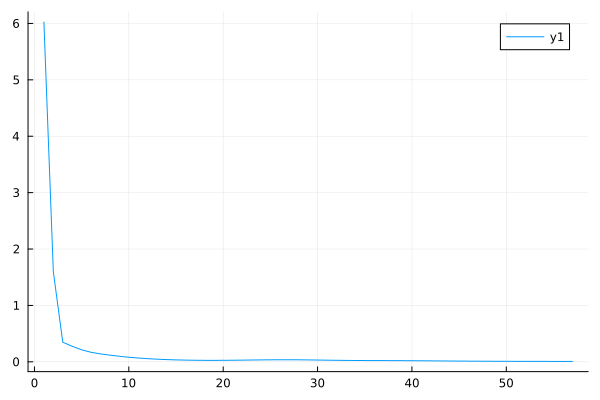

In [58]:
plot(param_diff)

In [59]:
param_diff[end]

0.00675751753174373